# Wildfire Impact Estimate in Pueblo, CO
## Notebook 3: Generating Wildfire Impact Metric, Comparing it AQI

In this notebook, I use the data I have pre-processed in [`fire_distance.ipynb`](./fire_distances.ipynb) to create a custom metric for wildfire impact.

Then, I analyze how this metric compares to the EPA's estimates of air quality (AQI).

### ATTRIBUTION
Some code, comments, and approaches below are based on notebooks from Dr. David McDonald,
who provided them for use in DATA 512, a course in the University of Washington MS of Data
Science Program. The code is provided and utilized here under the [Creative Commons CC-BY license.](https://creativecommons.org/licenses/by/4.0/)

## Setup & Data Import
After importing dependencies, I import the pre-processed wildfire data, now including distances to Pueblo, CO:

In [1]:
import json
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [2]:
# pre-processed data containing distances
with open("../intermediate_data/fire_features_with_distances.json", "r") as file:
    feature_list = json.load(file)

In [3]:
# shortest distances got saved as a list instead of a float
# transform them to floats
for feature in feature_list:
    feature["attributes"]["shortest_distance_to_pueblo"] = feature["attributes"]["shortest_distance_to_pueblo"][0]

Ultimately, after I develop & calculate the smoke intensity metric, I'll want to join it with the air quality index in another table to compare them. This will be easier if both are dataframes. The function below takes the GeoJSON wildfire data and converts it to a type of dataframe, making it easier to work with.

In [4]:
def convert_to_geodataframe(feature_list):
    
    # store processed features
    processed_features = []

    for i, feature in tqdm(enumerate(feature_list)):
        attributes = feature['attributes']
        geometry = feature.get('geometry')

        # some geometries are not rings; this can be problematic, so
        # I add a check and log exceptions
        if geometry and 'rings' in geometry:
            try:
                polygon = Polygon(geometry['rings'][0])
                processed_features.append({**attributes, 'geometry': polygon})

            except Exception as e:
                print(f"Problem with geometry for OBJECTID {
                      attributes.get('OBJECTID')}: {e}")

        elif geometry and 'curveRings' in geometry:
            try:
                polygon = Polygon(geometry['curveRings'][0])
                processed_features.append({**attributes, 'geometry': polygon})

            except Exception as e:
                print(f"Problem with geometry for OBJECTID {
                      attributes.get('OBJECTID')}: {e}")
        else:
            print(f"Skipping feature with OBJECTID {attributes.get(
                'OBJECTID')}: No 'rings' found. Instead, got: {geometry}\n")

    gdf = gpd.GeoDataFrame(processed_features, geometry='geometry')
    return gdf

In [5]:
gdf = convert_to_geodataframe(feature_list)

111819it [00:11, 13461.52it/s]

Problem with geometry for OBJECTID 109605: could not convert string to float: 'b'
Problem with geometry for OBJECTID 110224: could not convert string to float: 'a'
Problem with geometry for OBJECTID 110639: could not convert string to float: 'b'
Problem with geometry for OBJECTID 111431: could not convert string to float: 'a'
Problem with geometry for OBJECTID 111897: could not convert string to float: 'b'
Problem with geometry for OBJECTID 112410: could not convert string to float: 'a'
Problem with geometry for OBJECTID 112415: could not convert string to float: 'a'


116821it [00:12, 15586.61it/s]

Problem with geometry for OBJECTID 113411: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113665: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113738: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113766: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113805: could not convert string to float: 'a'
Problem with geometry for OBJECTID 114309: could not convert string to float: 'a'
Problem with geometry for OBJECTID 114322: could not convert string to float: 'a'
Problem with geometry for OBJECTID 115629: could not convert string to float: 'a'
Problem with geometry for OBJECTID 115974: could not convert string to float: 'a'
Problem with geometry for OBJECTID 116235: could not convert string to float: 'c'


120709it [00:12, 17523.00it/s]

Problem with geometry for OBJECTID 117086: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119582: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119617: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119751: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119982: could not convert string to float: 'a'
Problem with geometry for OBJECTID 120212: could not convert string to float: 'a'
Problem with geometry for OBJECTID 120678: could not convert string to float: 'a'


124252it [00:12, 16555.22it/s]

Problem with geometry for OBJECTID 121010: could not convert string to float: 'a'
Problem with geometry for OBJECTID 122264: could not convert string to float: 'a'


127530it [00:12, 15574.35it/s]

Problem with geometry for OBJECTID 125745: could not convert string to float: 'a'
Problem with geometry for OBJECTID 127492: could not convert string to float: 'a'


135061it [00:13, 10337.60it/s]


Now that the data is converted to a `geodataframe` object, I explore it and filter it to meet the specifications of this analysis in the next section.

## Data Exploration & Simplification

The section below documents my data exploration to figure out which columns to keep and drop.

In [6]:
# print the columns of the dataframe to figure out what's in here and what can be dropped
gdf.columns

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'shortest_distance_to_pueblo', 'centroid_distance_to_pueblo',
       'geometry'],
      dtype='object')

In [7]:
# these columns are potentially interesting
# for developing a metric of smoke intensity; 
# others can be dropped to make working w this
# data faster
columns_to_include = [
    "USGS_Assigned_ID",
    "Assigned_Fire_Type",
    "Fire_Year",
    "GIS_Acres",
    "Shape_Length",
    "Shape_Area",
    "shortest_distance_to_pueblo",
    "centroid_distance_to_pueblo",
    "geometry"
]

simplified_gdf = (gdf.
                  filter(columns_to_include))

The assignment specification indicates that we are interested in subsetting the data in a few ways:
- We only want to develop an estimate of smoke impact for fires within **650 miles** of Pueblo
- We only want to show the **number of fires** within 1800 miles of Pueblo
- We are interested in how **wildfires** impact air quality – PRESUMABLY THIS EXCLUDES PRESCRIBED BURNS

I perform those transformations in the cells below, then use them in later sections of the notebook.

In [8]:
DISTANCE_CUTOFF = 1800

fires_within_1800_mi = (
    simplified_gdf
    .pipe(lambda x: x[x['centroid_distance_to_pueblo'] <= DISTANCE_CUTOFF])
)

fires_within_1800_mi.head(3)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
0,1,Wildfire,1860,3940.207089,64888.449849,1.594545e+07,1137.124505,1139.206473,"POLYGON ((-1883775.596 1194154.192, -1883782.4..."
1,2,Wildfire,1860,772.518249,23462.288613,3.126270e+06,1135.778280,1136.854043,"POLYGON ((-1887470.131 1187759.244, -1887546.2..."
2,3,Wildfire,1860,333.020409,6679.573569,1.347686e+06,1138.124278,1138.643550,"POLYGON ((-1889386.119 1190683.928, -1889454.1..."


In [9]:
wildfires_within_1800_mi = (
    fires_within_1800_mi
    .pipe(lambda x: x[x["Assigned_Fire_Type"] == "Wildfire"])
)

wildfires_within_1800_mi.head(3)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
0,1,Wildfire,1860,3940.207089,64888.449849,1.594545e+07,1137.124505,1139.206473,"POLYGON ((-1883775.596 1194154.192, -1883782.4..."
1,2,Wildfire,1860,772.518249,23462.288613,3.126270e+06,1135.778280,1136.854043,"POLYGON ((-1887470.131 1187759.244, -1887546.2..."
2,3,Wildfire,1860,333.020409,6679.573569,1.347686e+06,1138.124278,1138.643550,"POLYGON ((-1889386.119 1190683.928, -1889454.1..."


In [10]:
CLOSER_FIRE_CUTOFF = 650

wildfires_within_650_mi = (
    wildfires_within_1800_mi
    .pipe(lambda x: x[x["centroid_distance_to_pueblo"] <= CLOSER_FIRE_CUTOFF])
)

wildfires_within_650_mi.head(3)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
4,5,Wildfire,1870,36.985574,2937.265383,1.496753e+05,637.107402,637.246282,"POLYGON ((-1371410.414 595942.396, -1371424.53..."
8,9,Wildfire,1880,14946.172721,64423.416282,6.048502e+07,39.263196,43.833024,"POLYGON ((-741983.427 -101388.883, -741883.607..."
9,10,Wildfire,1880,3115.787359,16474.164949,1.260914e+07,418.727182,420.305756,"POLYGON ((-606723.741 539312.302, -606687.256 ..."


In [11]:
YEAR_CUTOFF = 1961

close_wildfires_since1961 = (
    wildfires_within_650_mi
    .pipe(lambda x: x[x["Fire_Year"] >= YEAR_CUTOFF])
)

close_wildfires_since1961.head(3)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
13535,13536,Wildfire,1961,9691.440667,46801.824908,3.921987e+07,626.124172,628.293842,"POLYGON ((-1669193.583 -252228.935, -1669188.7..."
13545,13546,Wildfire,1961,5941.755818,24609.660290,2.404543e+07,582.357461,586.577089,"POLYGON ((-1394870.85 448209.973, -1394857.289..."
13548,13549,Wildfire,1961,9870.377328,28134.851067,3.994400e+07,195.308979,197.778156,"POLYGON ((-891047.798 -449060.664, -891257.758..."


## Defining the Smoke Estimate


How much smoke affects a point in space (in my case, Pueblo, CO) should increase with the acreage burned and decrease with the distance from the source.

Already, this requires making a choice, since we have two notions of distance available in our data: do we use the centroid distance (Pueblo, CO to the centroid of the fire area) or the edge distance (Pueblo to the closest point in the fire area).

I hypothesized that it wouldn't make a big difference for most fires, since most fires aren't very large. To test this, I checked the data:


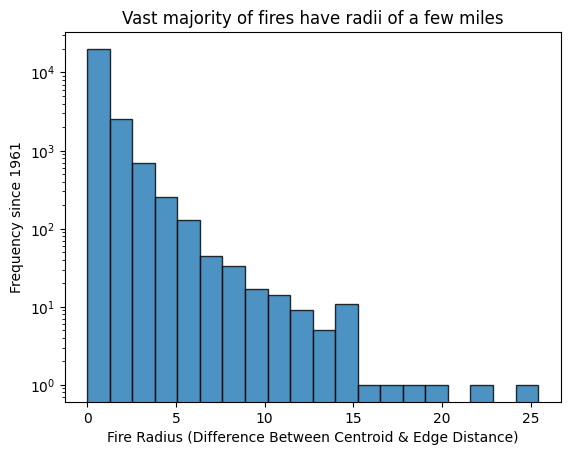

In [12]:
# if we approximate the average fire as a "circle", the radius
# is the difference between the distance to the centroid and
# the distance to the closest edge of the fire (from the perspective
# of Pueblo)
fire_radius = close_wildfires_since1961["centroid_distance_to_pueblo"] - \
    close_wildfires_since1961["shortest_distance_to_pueblo"]

plt.hist(fire_radius, bins=20, alpha=0.8, edgecolor="black")
plt.yscale("log")
plt.title("Vast majority of fires have radii of a few miles")
plt.xlabel("Fire Radius (Difference Between Centroid & Edge Distance)")
plt.ylabel("Frequency since 1961")
plt.show()

A few outlier fires have larger radii; most are small.

Therefore, to simplify modeling, I will use the **centroid distance**. This allows me to (simplistically) simulate the fire as coming from a point source, with all of the burning acreage coming from that point source. At the same time, using the centroid distance doesn't sacrifice much vs. using the edge distance, since in most cases these are basically equivalent.

Moreover, I will assume that the point source generates some volume of smoke, and that _on average_ (across all wildfires since 1961) this smoke dissipates roughly equally in all directions. This is not completely because there are systematic factors (terrain, wind patterns) that mean smoke does not spread equally in all directions, but it is a reasonable first approximation for my purposes.

The assumption that smoke dissipates equally in all directions from the point source allows me to use an inverse-square law. At a given point in time, a constant volume of smoke emanating from the point-source fills a half-sphere around the point source with radius $r$, where $r$ indicates the furthest point the smoke has reached. I will call this the "smoke radius"

Imagine some point $d$ (like a city), inside of the smoke radius ($d < r$). The volume of smoke inside of that point (between $d$ and the point source of the smoke) is proportional to $d^2$. Therefore, the smoke density at point $d$ is _inversely_ proportional to $d^2$.

Let $SIE$ indicate the Smoke Intensity Estimate. I want this to increase linearly with the acreage burned ($A$) and to be inversely proportional to the squared centroid distance $d$ between the city and the "point source" generating the smoke:

$$SIE \propto \frac{A}{d^2}$$


In the code below I implement this notion of smoke intensity. The units are irrelevant for my purposes, so I keep them as they are.

In [13]:
close_wildfires_since1961.loc[:, "smoke_intensity_est"] = (close_wildfires_since1961["GIS_Acres"] /
                                                           ((close_wildfires_since1961["centroid_distance_to_pueblo"])**2))

close_wildfires_since1961.head(3)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry,smoke_intensity_est
13535,13536,Wildfire,1961,9691.440667,46801.824908,3.921987e+07,626.124172,628.293842,"POLYGON ((-1669193.583 -252228.935, -1669188.7...",0.024551
13545,13546,Wildfire,1961,5941.755818,24609.660290,2.404543e+07,582.357461,586.577089,"POLYGON ((-1394870.85 448209.973, -1394857.289...",0.017269
13548,13549,Wildfire,1961,9870.377328,28134.851067,3.994400e+07,195.308979,197.778156,"POLYGON ((-891047.798 -449060.664, -891257.758...",0.252335


I output the results to sense-check them and get a sense for their distribution. The interquartile properties indicate the data is heavily left-skewed (most wildfires are far away from Pueblo and don't burn many acres) – this makes sense.

In [14]:
close_wildfires_since1961["smoke_intensity_est"].describe()

count    2.374700e+04
mean     3.931717e-02
std      8.710304e-01
min      4.040682e-11
25%      7.274812e-05
50%      5.155988e-04
75%      5.432039e-03
max      9.130211e+01
Name: smoke_intensity_est, dtype: float64

## Aggregating Annual Smoke Contributions from Many Fires

Ultimately, we are asked to produce an *annual* estimate of smoke impact. Each row in our dataset (associated with an acreage burned and a distance) represents *one fire* that burned during that fire season. Somehow, we have to aggregate the smoke effects of fires when we group by year to move from many records of fires to a single number representing smoke severity for that year.

There are a few options:
- `max()` - the most aggressive aggregation metric; choosing this would be saying, "the severity of a given year's fire seasson should be summarized by the *peak intensity* of smoke.
- `mean()`/`median()` choosing a measure of central tendency says, "what matters in summarizing the severity of a given year's fire season is how much smoke the *typical* fire emitted." These metrics *normalize* for the number of fires in a season.
- `sum()` - this treats different fires in a season cumulatively; choosing it says, "each fire contributes to the overall amount of smoke in the air during this season, and all smoke is relevant to what we're trying to measure. We *should not* normalize for the number of fires that burned; instead we should only look at the total amount of smoke."

The first option seems too aggressive; one extreme outlier could define an entire (otherwise unexceptional) fire season. So the question is whether we should normalize for the number of fires that burned or not. 

**I chose to treat fires that burn in a season cumulatively, adding up their contributions to the summarized smoke index for that season.** If wildfires are getting more frequent over time, but maintaining the same intensity, this would still be a problem: there's more smoke in the air, more of the time! We'd still want to capture it in any meaningful metric of air quality. But averaging/taking the median smoke level over the fires in a particular year would wash this effect out. The only way the smoke intensity estimate would increase over the years would be for the typical fire to get worse; but this fails to capture an important way (greater frequency) that fires can hurt air quality.

In [15]:
fie_by_year = (
    close_wildfires_since1961[["Fire_Year", "smoke_intensity_est"]] # we only care about these two columns now
    .groupby("Fire_Year") # aggregate data yearly
    .sum() # sum aggregation treats fires in a given year's fire season cumulatively
)

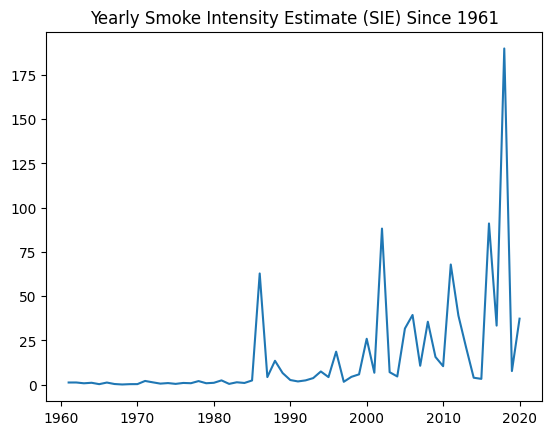

In [16]:
plt.plot(fie_by_year.index, fie_by_year["smoke_intensity_est"])
plt.title("Yearly Smoke Intensity Estimate (SIE) Since 1961")
plt.show()

**NOTE:** the assignment specifies that we should estimate wildfire smoke impact for each fire season. However, it notes, "the fire polygon data only (reliably) provide a year for each fire - it does not (reliably) provide specific start and end dates for the fire." Therefore, I have not filtered the USGS Wildfire Data to include only fires from May-October of each year, since this would eliminate a lot of records that do not reliably provide this information.



## AQI Data


The [`getting_aqi_data.ipynb`](./getting_aqi.data.ipynb) notebook dumps gaseous and particulate AQI data into [`intermediate_data`](../intermediate_data/) as separate files for each each. Below, I stitch them together and put them into a dataframe, so that I can aggregate to put them on a yearly scale and then join with my custom smoke estimate.

In [17]:
gaseous_aqi_prefix = "../intermediate_data/gaseous_aqi_"
particulate_aqi_prefix = "../intermediate_data/particulate_aqi_"

# by inspection of the intermediate_data folder, this 
# is the earliest year with data
START_YEAR = 1975
END_YEAR = 2023

# store overall aqi data
aqi_data = []

years = range(START_YEAR, END_YEAR)

for year in years:

    # open gaseous data JSON
    gaseous_filename = gaseous_aqi_prefix + str(year) + ".json"
    print(gaseous_filename)

    with open(gaseous_filename, "r") as gaseous_file:
        gaseous_data = json.load(gaseous_file)

    # append all of the features to the overall aqi data
    for d in gaseous_data["Data"]:
        d["year"] = year
        aqi_data.append(d)
    
    # open gaseous data JSON
    particulate_filename = particulate_aqi_prefix + str(year) + ".json"
    print(particulate_filename)

    with open(particulate_filename, "r") as particulate_file:
        particulate_data = json.load(particulate_file)
    
    # append all of the features to the overall aqi data
    for d in particulate_data["Data"]:
        d["year"] = year
        aqi_data.append(d)

# store AQI as df, making it easier to work with
aqi_df = pd.DataFrame(aqi_data)

../intermediate_data/gaseous_aqi_1975.json
../intermediate_data/particulate_aqi_1975.json
../intermediate_data/gaseous_aqi_1976.json
../intermediate_data/particulate_aqi_1976.json
../intermediate_data/gaseous_aqi_1977.json
../intermediate_data/particulate_aqi_1977.json
../intermediate_data/gaseous_aqi_1978.json
../intermediate_data/particulate_aqi_1978.json
../intermediate_data/gaseous_aqi_1979.json
../intermediate_data/particulate_aqi_1979.json
../intermediate_data/gaseous_aqi_1980.json
../intermediate_data/particulate_aqi_1980.json
../intermediate_data/gaseous_aqi_1981.json
../intermediate_data/particulate_aqi_1981.json
../intermediate_data/gaseous_aqi_1982.json
../intermediate_data/particulate_aqi_1982.json
../intermediate_data/gaseous_aqi_1983.json
../intermediate_data/particulate_aqi_1983.json
../intermediate_data/gaseous_aqi_1984.json
../intermediate_data/particulate_aqi_1984.json
../intermediate_data/gaseous_aqi_1985.json
../intermediate_data/particulate_aqi_1985.json
../interme

As a sense check, let's see what parameters are in the dataframe:

In [18]:
set(aqi_df["parameter"])

{'Acceptable PM2.5 AQI & Speciation Mass',
 'Carbon monoxide',
 'Nitrogen dioxide (NO2)',
 'Ozone',
 'PM10 Total 0-10um STP',
 'PM2.5 - Local Conditions',
 'Sulfur dioxide'}

These are the expected components of the Air Quality Index.

To make working with the dataframe easier, I drop columns that are irrelevant to this analysis:

In [19]:
aqi_df_ = aqi_df.drop(columns=[
    "parameter_code",
    "poc",
    "latitude",
    "longitude",
    "datum",
    "sample_duration_code",
    "sample_duration",
    "pollutant_standard",
    "event_type",
    "method_code",
    "method",
    "date_of_last_change",
    "site_address",
    "local_site_name"
])

When multiple contaminants are considered, overall AQI is calculated by taking the `max()` of all of the different contaminants. (Source: [Wikipedia](https://en.wikipedia.org/wiki/Air_quality_index#United_States)). 

To achieve this, I need to do a horizontal max across columns representing each of the six parameters in the AQI dataset. This, in turn, requires pivoting the data so that each parameter gets its own column (wide format).

The basic unit of analysis here is a measurement of a particular parameter on a particular date at a particular location. Sometimes, there are multiple measurements for a given parameter on a single day. When that happens, I average the different measurements taken for the same thing at different stations around Pueblo, CO.

In [20]:
index_columns = ["state", "county", "city",
                 "year", "date_local", "validity_indicator"]

columns_for_dedup = index_columns + ["parameter", "aqi"]

aqi_df_dedup = (aqi_df_[columns_for_dedup]
                .groupby(index_columns + ["parameter"])
                .mean()     # if multiple measurements of same parameter in pueblo
                            # occur on same day, take avg.
                .reset_index() # ensures columns are still accessible with df["column"]
)

aqi_df_dedup.head()

,state,county,city,year,date_local,validity_indicator,parameter,aqi
0,Colorado,Alamosa,Not in a city,1988,1988-03-24,N,Ozone,41.000000
1,Colorado,Alamosa,Not in a city,1988,1988-03-25,Y,Ozone,36.666667
2,Colorado,Alamosa,Not in a city,1988,1988-03-26,Y,Ozone,33.000000
3,Colorado,Alamosa,Not in a city,1988,1988-03-27,Y,Ozone,40.000000
4,Colorado,Alamosa,Not in a city,1988,1988-03-28,N,Ozone,45.000000


Having eliminated irrelevant columns and ensured that the table has one entry for each combination of state/county/city/date/validity, I can now pivot AQIs on parameters:

In [21]:
aqi_pivoted = (aqi_df_dedup.pivot(index=index_columns,
                                  columns="parameter",
                                  values="aqi")
               .reset_index() # ensures columns are still accessible with df["column"]
               .rename(columns={ # rename columns to make them easier to work with
                   "Acceptable PM2.5 AQI & Speciation Mass": "acceptable_pm2.5",
                   "Carbon monoxide": "co",
                   "Nitrogen dioxide (NO2)": "no2",
                   "Ozone": "o3",
                   "PM10 Total 0-10um STP": "pm10",
                   "PM2.5 - Local Conditions": "pm2.5_local",
                   "Sulfur dioxide": "so2"
               }))

Now, to get overall AQI I need to specify the columns I want to take the `max()` over:

In [22]:
AQI_POLLUTANTS = ["acceptable_pm2.5", "co",
                  "no2", "o3", "pm10", "pm2.5_local", "so2"]

We are asked to consider smoke impacts only during the fire season in this analysis; the code below re-filters the AQI data to consider only fire season months.

In [23]:
FIRE_SEASON_MONTHS = {5, 6, 7, 8, 9, 10} # fire season months represented as integers

fire_season_aqi = aqi_pivoted.loc[
    pd.to_datetime(
        aqi_pivoted["date_local"]).dt.month.isin(FIRE_SEASON_MONTHS)]

fire_season_aqi.head(3)

parameter,state,county,city,year,date_local,validity_indicator,acceptable_pm2.5,co,no2,o3,pm10,pm2.5_local,so2
39,Colorado,Alamosa,Not in a city,1988,1988-05-01,Y,NaN,NaN,NaN,67.000000,NaN,NaN,NaN
40,Colorado,Alamosa,Not in a city,1988,1988-05-02,Y,NaN,NaN,NaN,39.000000,NaN,NaN,NaN
41,Colorado,Alamosa,Not in a city,1988,1988-05-03,Y,NaN,NaN,NaN,33.666667,NaN,NaN,NaN


Right now, individual records represent the measurement of ONE parameter; but we want to sqeeze daily measurements in a particular location down to a single row, bringing together the rows representing each parameter. Below, I achieve this with another `groupby()` operation:

In [24]:
fire_season_aqi_daily = (fire_season_aqi[["date_local"] + AQI_POLLUTANTS]
                         .groupby("date_local")
                         .mean()    # there shouldn't me multiple measurements for a single
                                    # parameter anymore after the last aggregation; just in case, avg.
                                    # over the ones taken for that param that day
                         .reset_index() # ensures columns are still accessible with df["column"]
                         )

Finally, with rows now representing AQI measurements for the six different contaminants on the same day, we can get AQI by taking the horizontal max over those contaminants.

In [25]:
fire_season_aqi_daily["aqi_daily_est"] = fire_season_aqi_daily[AQI_POLLUTANTS].max(axis=1)

In [26]:
fire_season_aqi_daily["month"] = pd.to_datetime(
    fire_season_aqi_daily["date_local"]).dt.to_period("M")

Ultimately I want to get this data into yearly format. However, I don't want a particular month to contribute more to the index just because there happen to be more measurements during that month. So I first get an average monthly AQI, then move to yearly.

Moving from daily AQIs to yearly AQIs smooths out fluctuations in AQI, as would be expected. (See Supplementary Visualizations in Appendix for Daily and Monthly resolutions of AQI. While AQI never reaches [dangerous levels](https://en.wikipedia.org/wiki/Air_quality_index#United_States) for an entire year – this would be really bad it does sometimes hit dangerous levels on a given day.)

In [27]:
# replicate the procedure for daily aggreagtion to get a monthly aggregation
fire_season_aqi_monthly = (fire_season_aqi_daily[["month"] + AQI_POLLUTANTS]
                           .groupby("month")
                           .mean()
                           .reset_index())

In [28]:
# replicate the procedure for daily aggreagtion to get a monthly aggregation
fire_season_aqi_monthly["aqi_monthly_est"] = fire_season_aqi_monthly[AQI_POLLUTANTS].max(
    axis=1)

In [29]:
fire_season_aqi_monthly

parameter,month,acceptable_pm2.5,co,no2,o3,pm10,pm2.5_local,so2,aqi_monthly_est
0,1975-05,NaN,NaN,NaN,37.788889,NaN,NaN,NaN,37.788889
1,1975-06,NaN,NaN,NaN,46.011111,NaN,NaN,NaN,46.011111
2,1975-07,NaN,NaN,NaN,68.645161,NaN,NaN,NaN,68.645161
3,1975-08,NaN,34.516129,NaN,46.277778,NaN,NaN,NaN,46.277778
4,1975-09,NaN,36.466667,NaN,34.166667,NaN,NaN,NaN,36.466667
...,...,...,...,...,...,...,...,...,...
283,2022-06,25.400000,3.933333,NaN,52.766667,23.224359,25.166667,0.666667,52.766667
284,2022-07,14.666667,4.033333,NaN,61.580645,14.185185,20.983871,0.800000,61.580645
285,2022-08,13.700000,3.774194,NaN,64.580645,18.109195,24.967742,0.800000,64.580645
286,2022-09,12.571429,5.400000,NaN,49.622222,22.601190,28.333333,1.137931,49.622222


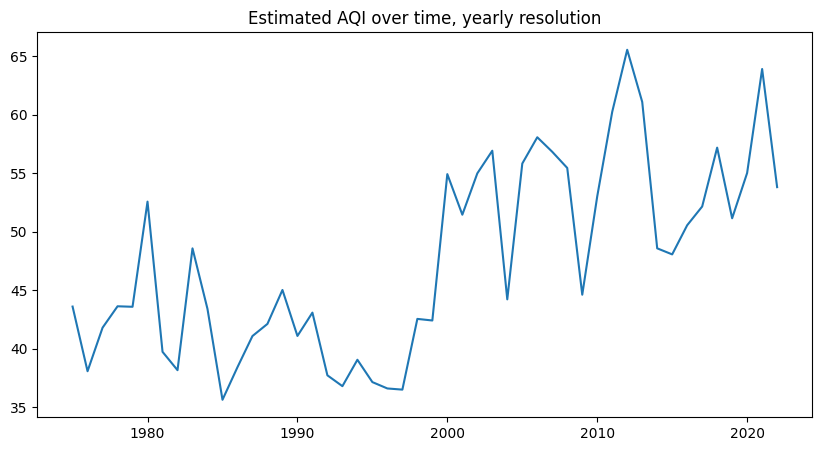

In [30]:
fire_season_aqi_daily["year"] = pd.to_datetime(
    fire_season_aqi_daily["date_local"]).dt.to_period("Y")

fire_season_aqi_yearly = (fire_season_aqi_daily[["year"] + AQI_POLLUTANTS]
                           .groupby("year")
                           .mean()
                           .reset_index())

fire_season_aqi_yearly["aqi_yearly_est"] = fire_season_aqi_yearly[AQI_POLLUTANTS].max(
    axis=1)

df = fire_season_aqi_yearly.copy()

plt.figure(figsize=(10, 5))
plt.plot(df["year"].dt.to_timestamp(), df["aqi_yearly_est"])
plt.title("Estimated AQI over time, yearly resolution")
plt.show()

In [31]:
fire_season_aqi_yearly = fire_season_aqi_yearly[["year", "aqi_yearly_est"]].set_index("year")

<div style="page-break-after: always;"></div>

## Is My Custom Metric a Good Predictor of AQI?

To assess whether my custom metric of smoke impact is good, I compare it to AQI via a scatterplot and by calculating its correlation coefficient.

In [32]:
# first need to do some data wrangling to set types correctly
# to allow a join
fie = np.array(fie_by_year.reset_index()["smoke_intensity_est"])
aqi = np.array(fire_season_aqi_yearly["aqi_yearly_est"])

# datetime years were causing problems, so revert to simple types
years = range(1961, 2021)

x = pd.DataFrame({
    "year": years,
    "fie": fie
})

years = range(1975, 2023)

y = pd.DataFrame({
    "year": years,
    "aqi": aqi
})

joined_estimates = x.merge(y, on="year", how="left").set_index("year")
joined_estimates.sample(10)

,fie,aqi
year,,
1965,0.239596,NaN
1985,2.329712,35.634058
1996,18.604578,36.601449
1978,1.976847,43.623188
1990,2.577317,41.088406
2014,3.879225,48.575181
2020,37.263605,55.011775
2008,35.538691,55.444444
1997,1.577448,36.501812


My smoke estimate and the EPA's AQI are moderately correlated:

In [33]:
joined_estimates.corr()

,fie,aqi
fie,1.00000,0.46037
aqi,0.46037,1.00000


We can see this visually as well:

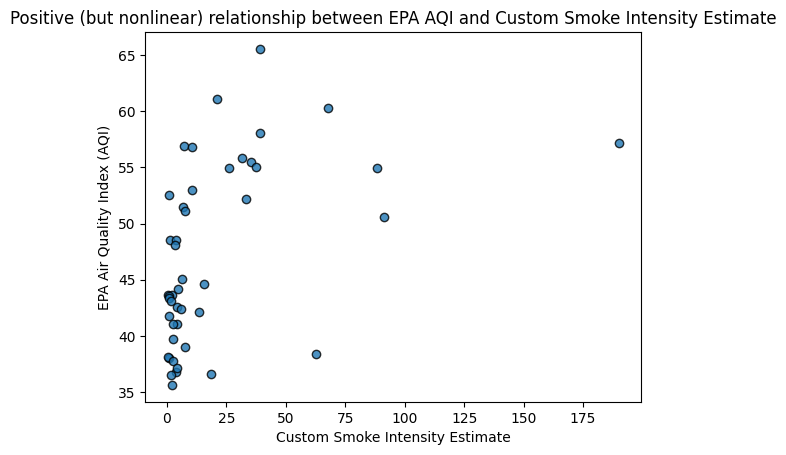

In [34]:
plt.scatter(data=joined_estimates, x="fie", y="aqi", alpha=0.8, edgecolors="black")
plt.title("Positive (but nonlinear) relationship between EPA AQI and Custom Smoke Intensity Estimate")
plt.xlabel("Custom Smoke Intensity Estimate")
plt.ylabel("EPA Air Quality Index (AQI)")
plt.show()

Visually, the peaks of FIE look like they lag the peaks of AQI (see Time Series of Fire Estimate and AQI in the Visualizations Section) so I was interested in the lagged correlation between the two variables. Unfortunately, the non-lagged correlations are stronger:

In [35]:
joined_estimates["fie_lagged"] = joined_estimates["fie"].shift(1)
joined_estimates.corr()

,fie,aqi,fie_lagged
fie,1.000000,0.460370,0.120678
aqi,0.460370,1.000000,0.375452
fie_lagged,0.120678,0.375452,1.000000


Overall, my custom metric is a moderate approximation of Air Quality as the EPA defines it.

## Predictive Model of Future Wildfire Smoke Intensity

After researching different predictive models consulting with collaborators (Sid G., Ed S.), I concluded that SARIMA would generate the best results.

The main reason I chose SARIMA is that, when reviewing the SIE values I generated, I noticed pronounced peaks in ~1985, ~2000, and the mid/late 2000s. This suggested that there was a seasonal component to my smoke intensity metric; it seems to peak every ~15 years. SARIMA allows me to capture this cyclicality by adjusting the seasonablity parameters. The code below models the observed data using a SARIMA model, then uses that model to make predictions about smoke intensity for the next 25 years.

### ATTRIBUTION

After collaborating with classmates (Sid G., Edouard S.) and reading about different time series models, I identified an autoregressive moving average time series model with a seasonal component (SARIMA) as an appropriate option. I researched this model to understand its parameters and appropriate use cases. 

However, because I have no experience implementing these models in Python, I used an AI tool to assist me in generating this model output and producing a visualization with shaded confidence intervals.

On October 30, 2024, I promoted ChatGPT: 
>"Show me how to create a predictive SARIMA model in python. The name of the dataframe with "fie" in it is joined_estimates."
 

I took the output it produced and made adjustments to the code.

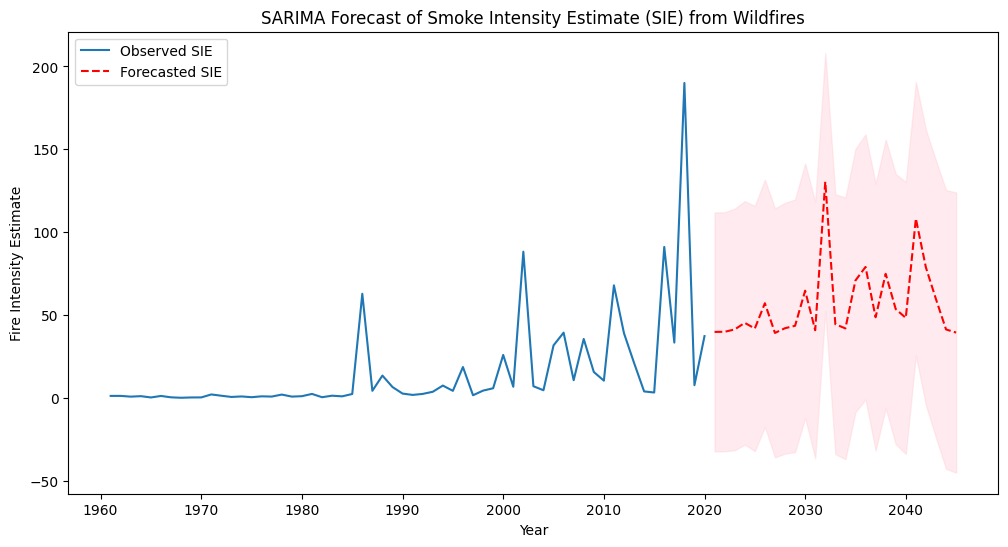

In [ ]:
### Below, I implement a seasonal autoregressive integrated moving average (SARIMA model)

# Some wrangling to ensure that year is interpreted as a time
joined_estimates.index = pd.to_datetime(joined_estimates.index, format="%Y")

# Set SARIMA model parameters
p, d, q = 1, 1, 1  # Trend parameters
P, D, Q, s = 1, 1, 1, 15  # Seasonality seems to run in ~15 year cycles

with warnings.catch_warnings(): # suppress warnings
    warnings.simplefilter("ignore")
    
    # Fit the model
    model = SARIMAX(joined_estimates["fie"],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    sarima_result = model.fit(disp=False)

    # Forecast the next 20 years
    forecast_steps = 25
    forecast = sarima_result.get_forecast(steps=forecast_steps)

    # Adjust the forecast index to start in the year after
    # the last obsservation
    last_year = joined_estimates.index[-1].year
    forecast_index = pd.date_range(start=f"{last_year}", periods=forecast_steps, freq="YE")

    # Get forecasted mean and confidence intervals
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(joined_estimates.index, joined_estimates["fie"], label="Observed SIE")
    plt.plot(forecast_index, forecast_mean, color="red", linestyle="--", label="Forecasted SIE")
    plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="pink", alpha=0.3)
    plt.title("SARIMA Forecast of Smoke Intensity Estimate (SIE) from Wildfires")
    plt.xlabel("Year")
    plt.ylabel("Fire Intensity Estimate")
    plt.legend()
    plt.show()


In [74]:
# Store the predictions...
forecast_df = pd.DataFrame({
    'Prediction': np.array(forecast.predicted_mean),
    'Lower CI': np.array(forecast.conf_int().iloc[:, 0]),
    'Upper CI': np.array(forecast.conf_int().iloc[:, 1])
}, index=forecast_index)

# ... and output them to a csv:
forecast_df.to_csv("../predictions/arima_predictions.csv")

## Visualizations

Below are the visualization deliverables for this analysis.

Number of fires occurring every 50-mile distance from Pueblo, CO (up to 1800 miles away)

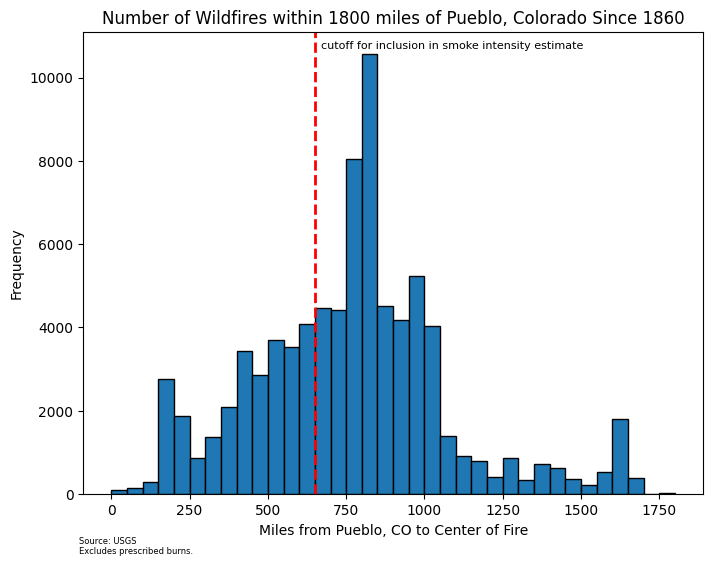

In [87]:
# Define the start and stop values
bins = np.linspace(0,1800,37)
plt.figure(figsize=(8,6))
plt.hist(wildfires_within_1800_mi["centroid_distance_to_pueblo"], # recall, these are very similar to edge distances 
         bins=bins, 
         edgecolor="black")
plt.title(f"Number of Wildfires within 1800 miles of Pueblo, Colorado Since {min(wildfires_within_1800_mi["Fire_Year"])}")
plt.xlabel("Miles from Pueblo, CO to Center of Fire")
plt.ylabel("Frequency")
plt.figtext(0.12, 0.01, 'Source: USGS\nExcludes prescribed burns.', ha='left', fontsize=6) # add a footnote
plt.axvline(x=650, color='red', linestyle='--', linewidth=2)
plt.annotate("cutoff for inclusion in smoke intensity estimate", 
             xy=(650, 0), 
             xytext=(670, 10700),
             fontsize=8, color='black')  # text properties
plt.show()

### Reflection

### Total Acres Burned by Year

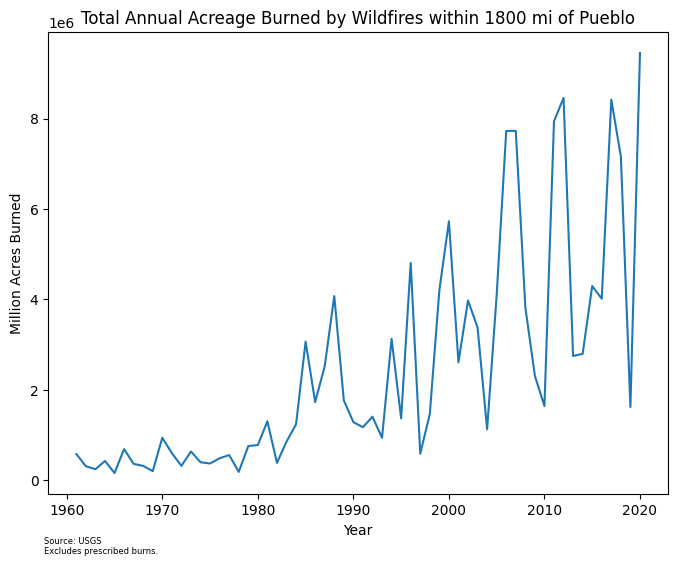

In [38]:
wildfires_within_1800_mi_since_1961 = (
    wildfires_within_1800_mi
    .loc[wildfires_within_1800_mi["Fire_Year"] >=1961, ["Fire_Year", "GIS_Acres"]]
    .groupby("Fire_Year")
    .sum()
)
plt.figure(figsize=(8,6))
plt.plot(wildfires_within_1800_mi_since_1961.index, wildfires_within_1800_mi_since_1961["GIS_Acres"]) 
plt.title("Total Annual Acreage Burned by Wildfires within 1800 mi of Pueblo")
plt.xlabel("Year")
plt.ylabel("Million Acres Burned")
plt.figtext(0.12, 0.01, 'Source: USGS\nExcludes prescribed burns.', ha='left', fontsize=6)
plt.show()

### Reflection

### Time Series of Fire Estimate and AQI

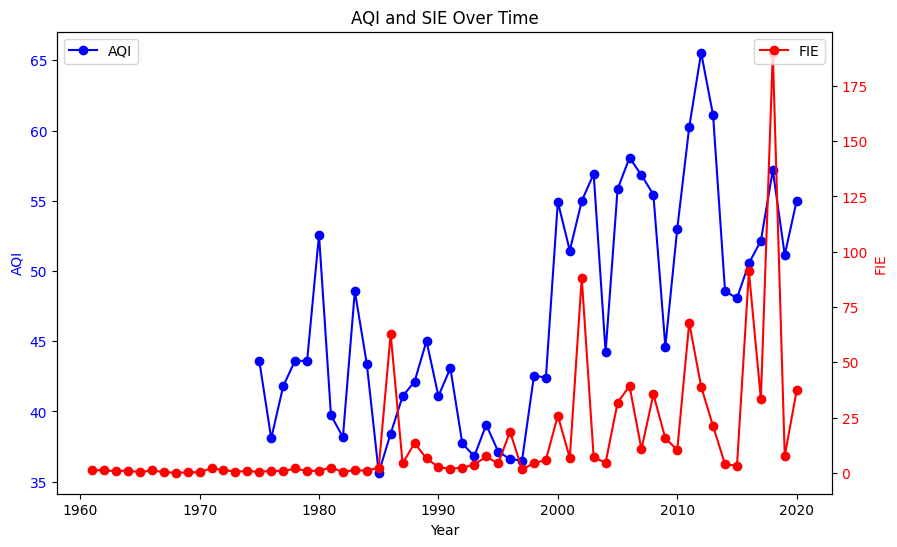

In [39]:
df_for_viz = joined_estimates

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_for_viz.index, df_for_viz['aqi'], color='b', label='AQI', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('AQI', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('AQI and SIE Over Time')

ax2 = ax1.twinx()
ax2.plot(df_for_viz.index, df_for_viz['fie'], color='r', label='FIE', marker='o')
ax2.set_ylabel('FIE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Reflection

## Appendix

### Supplementary Visualizations

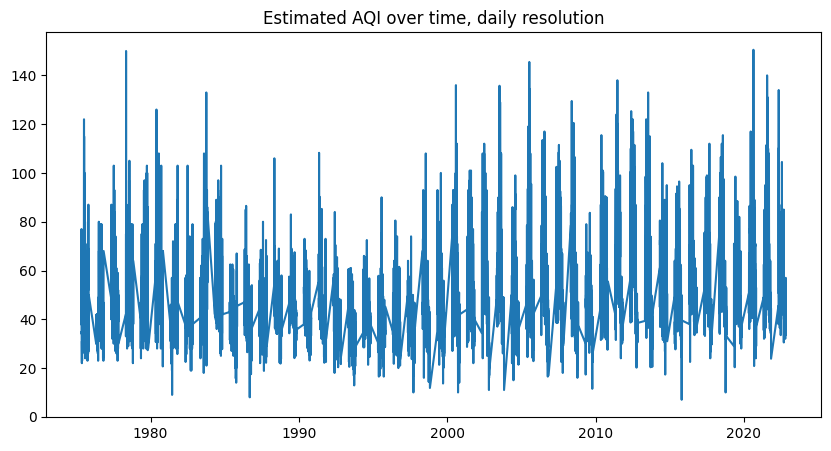

In [40]:
df = fire_season_aqi_daily.copy()

plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(df["date_local"]), df["aqi_daily_est"])
plt.title("Estimated AQI over time, daily resolution")
plt.show()

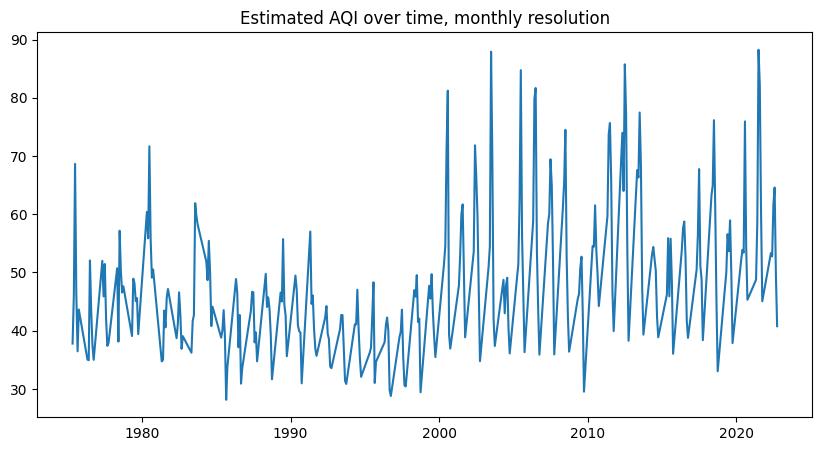

In [41]:
df = fire_season_aqi_monthly.copy()

plt.figure(figsize=(10, 5))
plt.plot(df["month"].dt.to_timestamp(), df["aqi_monthly_est"])
plt.title("Estimated AQI over time, monthly resolution")
plt.show()

### Data Processing Note
**Note**: the problem with AQI data is NOT that I am directly accessing AQIs rather than calculating it from the underlying raw concentrations; just as many of these are null as the AQI values.

In [42]:
aqi_pivoted.isna().mean()

parameter
state                 0.000000
county                0.000000
city                  0.000000
year                  0.000000
date_local            0.000000
validity_indicator    0.000000
acceptable_pm2.5      0.935369
co                    0.637626
no2                   0.786411
o3                    0.554100
pm10                  0.707943
pm2.5_local           0.888659
so2                   0.755768
dtype: float64